In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model'
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement

Station = Base.classes.station


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)


In [10]:
# Creating an inspector to explore the columns
inspector = inspect(engine)

# Exploratory Climate Analysis

#### Inspecting the columns within the two tables


In [11]:
# Columns in the Measurement Table
Measurement_Columns = inspector.get_columns('Measurement')

# For loop to print the columns
for column_measure in Measurement_Columns:
    print(column_measure['name'], column_measure['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Columns in the Station Table
Station_Columns = inspector.get_columns('Station')

# For loop to print the columns
for column_station in Station_Columns:
    print(column_station['name'], column_station['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


#### Design a query to retrieve the last 12 months of precipitation data and plot the results

In [13]:
# Determining the Entire Timeframe
total_time_frame = session.query(func.count(Measurement.date)).all()
total_time_frame[0]

(19550)

In [14]:
# Determining the Starting Date
start_date = session.query(Measurement.date).\
    order_by(Measurement.date).\
        first()

In [15]:
# Determining the Last Date
last_date = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).\
        first()

In [16]:
# Start and Finish Date of Record Keeping
print(f' The Starting Date is {start_date[0]} and the Last Date is {last_date[0]}')

 The Starting Date is 2010-01-01 and the Last Date is 2017-08-23


In [17]:
# Obtaining the Last Twelve Months of Precipitation
last_date_dt = dt.datetime.strptime(last_date[0],'%Y-%m-%d')


In [18]:
# Calculate the date 1 year ago from the last data point in the database - This will assist in obtaining all the data from this timepoint
query_date = dt.date(last_date_dt.year -1, last_date_dt.month, last_date_dt.day)
query_date

datetime.date(2016, 8, 23)

In [19]:
# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, Measurement.prcp]

precipitation_query = session.query(*sel).filter(Measurement.date >= query_date).all()

In [20]:
# Save the query results as a Pandas DataFrame and set the index to the date column
twelve_month_prcp = pd.DataFrame(precipitation_query, columns=['Date', 'Precipitation'])

twelve_month_prcp.set_index('Date', inplace=True)
twelve_month_prcp.head()


,Precipitation
Date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [21]:
# Sort the dataframe by date
twelve_month_prcp = twelve_month_prcp.sort_index(ascending=True)
twelve_month_prcp

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


In [22]:
# Removing the NaN values
twelve_month_prcp = twelve_month_prcp.dropna(how='any')
twelve_month_prcp

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


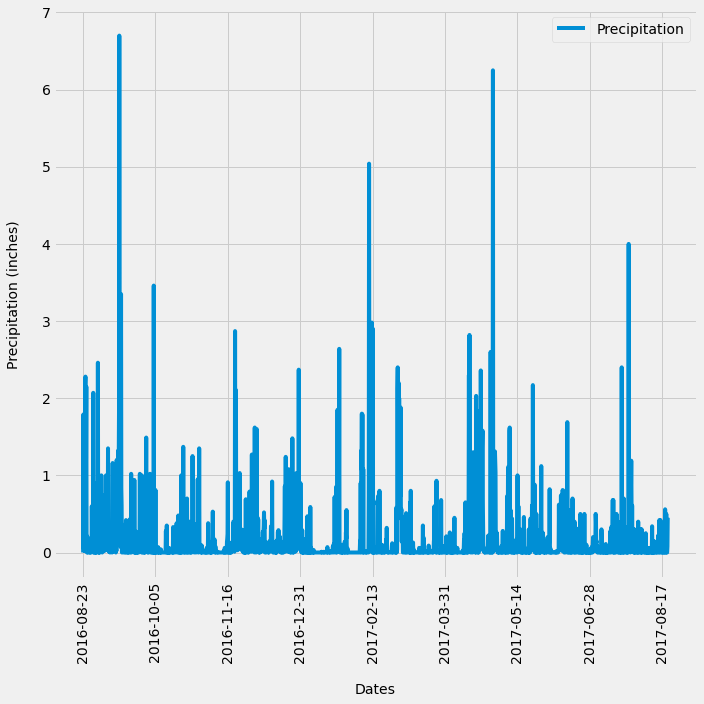

In [23]:
# Use Pandas Plotting with Matplotlib to plot the data
twelve_month_prcp.plot(rot=90, figsize=(10,10))
plt.legend(loc='upper right')
plt.ylabel('Precipitation (inches)\n',fontsize=14)
plt.xlabel('\nDates', fontsize=14)
plt.tight_layout() # This ensures the labels are retained when exporting images
plt.savefig('Images/precipitation.png', bbox_inches='tight')
plt.show()

In [24]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_statistics_precipitation = twelve_month_prcp.describe()

print(f'The Summary Statistics for Precipitation are:\n\n{summary_statistics_precipitation}')

The Summary Statistics for Precipitation are:

       Precipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


In [25]:
# Design a query to show how many stations are available in this dataset?
stations_count = session.query(func.count(Station.station)).all()

for c in stations_count:
    print(f'The total number of stations in the dataset is {c[0]} Stations')



The total number of stations in the dataset is 9 Stations


In [26]:
# What are the most active stations? (i.e. what stations have the most rows)?
active_station_count = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).all()


In [27]:
# List the stations and the counts in descending order.
for asc in active_station_count:
    print((f'Station ID - {asc[0]}| Count = {asc[1]}\n'))
    

Station ID - USC00519281| Count = 2772

Station ID - USC00519397| Count = 2724

Station ID - USC00513117| Count = 2709

Station ID - USC00519523| Count = 2669

Station ID - USC00516128| Count = 2612

Station ID - USC00514830| Count = 2202

Station ID - USC00511918| Count = 1979

Station ID - USC00517948| Count = 1372

Station ID - USC00518838| Count = 511



In [28]:
# Using the station id from the previous query, calculate the lowest temperature recorded,
# highest temperature recorded, and average temperature of the most active station?

sel1 = [func.min(Measurement.tobs), func.max(Measurement.tobs),func.avg(Measurement.tobs)]

active_station_analysis = session.query(*sel1).\
    group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).first()


print(f'The Lowest Recorded Temperature is {active_station_analysis[0]}\n\nThe Maximum Recorded Temperature is {active_station_analysis[1]}\n\nThe Average Temperature for Station {max(active_station_count)[0]} is {round(active_station_analysis[2],2)}')

The Lowest Recorded Temperature is 54.0

The Maximum Recorded Temperature is 85.0

The Average Temperature for Station USC00519523 is 71.66


In [29]:
# Choose the station with the highest number of temperature observations.
top_station = print(f'The Station with the highest number of temperature observations is {max(active_station_count)[0]}')


The Station with the highest number of temperature observations is USC00519523


In [30]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_top_obs = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
        filter(Measurement.date >= query_date).all()

In [31]:
# In order the plot the data, the list will need to be flattened
temperature_top_obs = list(np.ravel(station_top_obs))

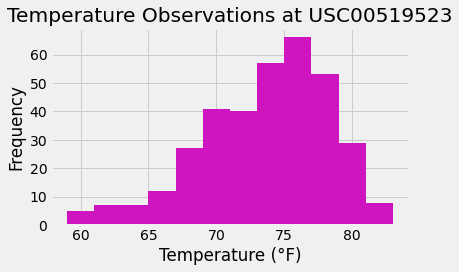

In [32]:
# Plotting the Temperatures as a Histogram
plt.hist(temperature_top_obs, bins=12, color='#cf15bf')
plt.title(f'Temperature Observations at {max(active_station_count)[0]}')
plt.ylabel(f'Frequency')
plt.xlabel(f'Temperature (°F)')
plt.tight_layout()
plt.savefig(f'Images/temperature_at_{max(active_station_count)[0]}.png', bbox_inches='tight')
plt.show()

## Bonus Challenge Assignment

In [33]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [34]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# The trip will be undertaken in 2017-07-01 and end on 2017-07-31

print(f'Min, Average, Max')
print(calc_temps('2016-07-01', '2016-07-31'))


Min, Average, Max
[(71.0, 77.45989304812834, 83.0)]


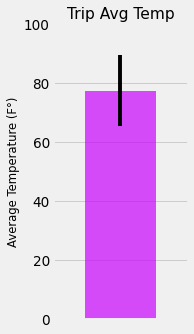

In [35]:
# Plot the results from your previous query as a bar chart.
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip_temp = np.ravel((calc_temps('2016-07-01', '2016-07-31')), order='C')

x_value = 0
y_value = trip_temp[1] # Average Temperature
error_bar = trip_temp[2] - trip_temp[0]
plt.figure(figsize=(3,5), dpi = 70)
plt.bar(x_value, y_value, yerr = error_bar, color='#ca03fc', alpha=0.7)
plt.title('Trip Avg Temp', fontsize=16)
plt.xlim(-0.75, 0.75)
plt.ylim(0,100)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.ylabel('Average Temperature (F°)', fontsize=12)
plt.grid(which='major', axis='x', linestyle='')
plt.tight_layout()
plt.savefig('Images/Trip_average_temp.png',bbox_inches='tight')
plt.show()


In [36]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

starting_date = '2016-07-01'
ending_date = '2016-07-31'

sel = [Station.name, Measurement.station, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]


precipitation_data = session.query(*sel).\
    filter(Measurement.station == Station.station).\
        group_by(Measurement.station).\
            filter(Measurement.date >= starting_date).\
                filter(Measurement.date <= ending_date).\
                    order_by(func.sum(Measurement.prcp).desc()).all()

# For a better view of the data, the query will be converted into a Pandas DataFrame
precipitation_data_df = pd.DataFrame(precipitation_data, columns=['Station Name','Station','Latitude', 'Longitude', 'Elevation','Total Precipitation'])

precipitation_data_df




,Station Name,Station,Latitude,Longitude,Elevation,Total Precipitation
0,"MANOA LYON ARBO 785.2, HI US",USC00516128,21.33310,-157.80250,152.4,22.41
1,"WAIHEE 837.5, HI US",USC00519281,21.45167,-157.84889,32.9,16.74
2,"KANEOHE 838.1, HI US",USC00513117,21.42340,-157.80150,14.6,10.75
3,"WAIKIKI 717.2, HI US",USC00519397,21.27160,-157.81680,3.0,6.33
4,"WAIMANALO EXPERIMENTAL FARM, HI US",USC00519523,21.33556,-157.71139,19.5,6.14
5,"KUALOA RANCH HEADQUARTERS 886.9, HI US",USC00514830,21.52130,-157.83740,7.0,2.59
6,"PEARL CITY, HI US",USC00517948,21.39340,-157.97510,11.9,0.51


In [37]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [38]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date_1 = '2017-07-01' 
end_date_1 = '2017-07-31'

# Use the start and end date to create a range of dates
date_start_1 = dt.datetime.strptime(start_date_1, '%Y-%m-%d')
date_end_1 = dt.datetime.strptime(end_date_1,'%Y-%m-%d')

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

dates_for_trip = []
temp_normals = []

while (date_start_1 <= date_end_1):
    dates_for_trip.append(dt.datetime.strftime(date_start_1, '%Y-%m-%d'))
    date_string = dt.datetime.strftime(date_start_1,'%m-%d')
    temp_normals.append(list(np.ravel(daily_normals(date_string))))
    date_start_1 = date_start_1 + dt.timedelta(days=1)

temp_normals


[[67.0, 74.77777777777777, 81.0],
 [68.0, 75.40384615384616, 82.0],
 [68.0, 75.32075471698113, 87.0],
 [70.0, 76.57142857142857, 81.0],
 [66.0, 75.0, 81.0],
 [69.0, 75.0, 81.0],
 [69.0, 74.91071428571429, 82.0],
 [69.0, 76.08333333333333, 83.0],
 [68.0, 76.19298245614036, 83.0],
 [68.0, 75.62068965517241, 82.0],
 [70.0, 75.78947368421052, 81.0],
 [67.0, 75.96491228070175, 82.0],
 [69.0, 76.1896551724138, 81.0],
 [61.0, 76.2280701754386, 82.0],
 [68.0, 76.2542372881356, 82.0],
 [70.0, 76.34482758620689, 83.0],
 [70.0, 76.30188679245283, 83.0],
 [72.0, 76.63793103448276, 83.0],
 [68.0, 75.89090909090909, 83.0],
 [69.0, 75.46296296296296, 82.0],
 [69.0, 76.9245283018868, 83.0],
 [69.0, 75.78846153846153, 81.0],
 [70.0, 76.20370370370371, 84.0],
 [69.0, 76.55555555555556, 81.0],
 [67.0, 76.89090909090909, 84.0],
 [71.0, 76.4423076923077, 86.0],
 [68.0, 76.58181818181818, 83.0],
 [69.0, 76.46428571428571, 82.0],
 [69.0, 76.47058823529412, 83.0],
 [69.0, 77.35185185185185, 84.0],
 [72.0, 77.

In [39]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

planned_trip_df = pd.DataFrame(temp_normals, columns = ['Min Temp', 'Average', 'Max Temp'])

# Adding dates to the columns
planned_trip_df['Dates'] = dates_for_trip

# Setting the index to date
planned_trip_df = planned_trip_df.set_index('Dates')
planned_trip_df.head()


,Min Temp,Average,Max Temp
Dates,,,
2017-07-01,67.0,74.777778,81.0
2017-07-02,68.0,75.403846,82.0
2017-07-03,68.0,75.320755,87.0
2017-07-04,70.0,76.571429,81.0
2017-07-05,66.0,75.000000,81.0


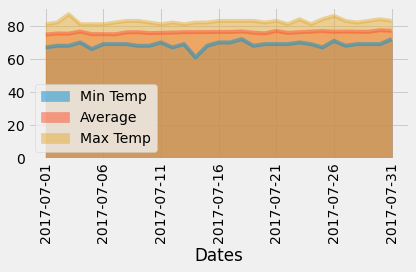

In [40]:
# Plot the daily normals as an area plot with `stacked=False`
planned_trip_df.plot.area(stacked=False)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('Images/daily_normals.png',bbox_inches='tight')
plt.show()


#### Calculating the Differences between June and December Temperature Averages

In [41]:
# Calculating the Differences between June and December Temperature Averages
measurement_df = pd.read_csv('Resources/hawaii_measurements.csv')

station_df = pd.read_csv('Resources/hawaii_stations.csv')

In [42]:
# Measurement DF
measurement_df.head()

,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65
1,USC00519397,2010-01-02,0.00,63
2,USC00519397,2010-01-03,0.00,74
3,USC00519397,2010-01-04,0.00,76
4,USC00519397,2010-01-06,NaN,73


In [43]:
# Stations DF
station_df.head()

,station,name,latitude,longitude,elevation
0,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [44]:
# Merging the two DataFrames
merged_df = pd.merge(measurement_df, station_df, how='inner', on='station')
merged_df

,station,date,prcp,tobs,name,latitude,longitude,elevation
0,USC00519397,2010-01-01,0.08,65,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,USC00519397,2010-01-02,0.00,63,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
2,USC00519397,2010-01-03,0.00,74,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
3,USC00519397,2010-01-04,0.00,76,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
4,USC00519397,2010-01-06,NaN,73,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
...,...,...,...,...,...,...,...,...
19545,USC00516128,2017-08-19,0.09,71,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4
19546,USC00516128,2017-08-20,NaN,78,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4
19547,USC00516128,2017-08-21,0.56,76,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4
19548,USC00516128,2017-08-22,0.50,76,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4


In [45]:
# Filtering time based on dates
june_temp_filter = merged_df[merged_df['date'].str.contains('-06-')]

june_temp_list = june_temp_filter['tobs'].tolist()

june_average = june_temp_filter['tobs'].mean()

In [56]:
# December Averages
december_temp_filter = (merged_df[merged_df['date'].str.contains('-12-')])

december_temp_list = december_temp_filter['tobs'].tolist()

december_average = december_temp_filter['tobs'].mean()



In [58]:
december_average

71.04152933421226

In [61]:
# The June and December Temperature averages
print(f'The average temperature throughout the years for june are {round(june_average,2)}\n\nThe average temperature throughout the years for december are {round(december_average,2)}')

The average temperature throughout the years for june are 74.94

The average temperature throughout the years for december are 71.04


In [78]:
# Conduting an independent ttest to compare temperature averages between 
from scipy import stats
tStat,pValue = stats.ttest_ind(june_temp_list, december_temp_list, equal_var=False)

print(f'Null hypothesis: june_avg = dec_avg\n\nAlternative Hypothesis: june_avg =! dec_avg\n\n')

if pValue < 0.05:
    print(f'p-value {pValue} is less than 0.05, so reject the null hypothesis\n\nConlusion, temperature averages are different for June and December')
else:
    print(f'The temperatures are not significantly different')

Null hypothesis: june_avg = dec_avg

Alternative Hypothesis: june_avg =! dec_avg


p-value 4.193529835915756e-187 is less than 0.05, so reject the null hypothesis

Conlusion, temperature averages are different for June and December
